# Pytorch Unet image segmentation

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset
import torchvision
import torchvision.transforms as transforms

import functools

import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler

from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP

from torch.distributed.fsdp.fully_sharded_data_parallel import (
    CPUOffload,
    BackwardPrefetch,
)

from torch.distributed.fsdp.wrap import (
    size_based_auto_wrap_policy,
    enable_wrap,
    wrap,
)

In [2]:
import numpy as np
from glob import glob
from PIL import Image

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Import data

In [4]:
# the indicator of a fresh run
first_time_running = False

# user-specified working directory
filepath = '/glade/campaign/cisl/aiml/ksha/Pytorch_example_data/oxford_iiit/'

In [5]:
if first_time_running:
    # downloading and executing data files
    import tarfile
    import urllib.request
    
    filename_image = filepath+'images.tar.gz'
    filename_target = filepath+'annotations.tar.gz'
    
    urllib.request.urlretrieve('http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz', filename_image);
    urllib.request.urlretrieve('https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz', filename_target);
    
    with tarfile.open(filename_image, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)
    with tarfile.open(filename_target, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)

## Build model

In [6]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels1, in_channels2, out_channels):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = DoubleConv(in_channels1, out_channels)
        self.conv2 = DoubleConv(out_channels+in_channels2, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.conv1(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv2(x)
        return x

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.inc = (DoubleConv(n_channels, 64))
        
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        
        self.up1 = (Up(1024, 512, 512))
        self.up2 = (Up(512, 256, 256))
        self.up3 = (Up(256, 128, 128))
        self.up4 = (Up(128, 64, 64))
        
        self.outc = (OutConv(64, n_classes))
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        #x = self.softmax(x)
        return x

## Data pre-processing

In [7]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def shuffle_ind(L):
    ind = np.arange(L)
    np.random.shuffle(ind)
    return ind

def image_to_array(filenames, size, channel):
    # number of files
    L = len(filenames)
    
    # allocation
    out = np.empty((L, size, size, channel))
    
    # loop over filenames
    if channel == 1:
        for i, name in enumerate(filenames):
            with Image.open(name) as pixio:
                pix = pixio.resize((size, size), Image.NEAREST)
                out[i, ..., 0] = np.array(pix)
    else:
        for i, name in enumerate(filenames):
            with Image.open(name) as pixio:
                pix = pixio.resize((size, size), Image.NEAREST)
                out[i, ...] = np.array(pix)[..., :channel]
    return out[:, ::-1, ...]

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [8]:
sample_names = np.array(sorted(glob(filepath+'images/*.jpg')))
label_names = np.array(sorted(glob(filepath+'annotations/trimaps/*.png')))

L = len(sample_names)
ind_all = shuffle_ind(L)

L_train = int(0.96*L)
L_valid = int(0.02*L)
L_test = L - L_train - L_valid
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:L_train+L_valid]; ind_test = ind_all[L_train+L_valid:]

print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, L_test))

Training:validation:testing = 7094:147:149


### Training using Pytorch pipeline 

**Create dataloaders**

In [10]:
class base_loader(Dataset):

    def __init__(self, filename_input, filename_target, size, channel_input, channel_target):
        self.filename_input = filename_input
        self.filename_target = filename_target
        self.size = size
        self.channel_input = channel_input
        self.channel_target = channel_target

    def __len__(self):
        # return total number of samples
        return len(self.filename_input)

    def __getitem__(self, index):
        # return a single input-target pair
        
        # get single file names
        filename_input_single = [self.filename_input[index],]
        filename_target_single = [self.filename_target[index],]

        # get size info
        size = self.size
        channel_input = self.channel_input
        channel_target = self.channel_target

        # input preprocessing
        train_input = image_to_array(filename_input_single, size, channel_input)
        train_input = input_data_process(train_input)
        train_input = np.transpose(train_input, [0, 3, 1, 2])[0, ...]
        train_input = torch.from_numpy(train_input).float()

        # target preprocessing
        train_target = image_to_array(filename_target_single, size, channel_target)
        train_target = train_target[..., 0].astype(int)
        train_target = train_target - 1
        train_target = to_categorical(train_target, num_classes=3)
        train_target = np.transpose(train_target, [0, 3, 1, 2])[0, ...]
        train_target = torch.from_numpy(train_target.copy()).float()
        
        return train_input, train_target

In [60]:
# Test dataloader
# train_data = base_loader(sample_names[ind_train], label_names[ind_train], 
#                          size=128, channel_input=3, channel_target=1)

# valid_data = base_loader(sample_names[ind_valid], label_names[ind_valid], 
#                          size=128, channel_input=3, channel_target=1)

# train_loader = DataLoader(train_data, batch_size=N_sample, shuffle=True)
# valid_loader = DataLoader(valid_data, batch_size=N_sample, shuffle=False)

## Model training with FSDP

In [13]:
def setup(rank, world_size):
    # ?? don't know what is this
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

In [29]:
def train(model, train_loader, loss_func, optimizer, rank, world_size, epoch, sampler=None):
    '''
    train model on a single epoch
    '''
    # switch to training mode
    model.train()

    # allocate training loss
    ddp_loss = torch.zeros(2).to(rank)

    # set the current epoch on sampler
    if sampler:
        sampler.set_epoch(epoch)

    # roll out batches for a single epoch
    for batch_idx, (train_input, train_target) in enumerate(train_loader):
        
        # project data to device 
        train_input = train_input.to(rank)
        train_target = train_target.to(rank)
        
        optimizer.zero_grad()
        y_pred = model(train_input)
        
        loss = loss_func(y_pred, train_target, reduction='sum')
        loss.backward()
        optimizer.step()
        
        ddp_loss[0] += loss.item()
        ddp_loss[1] += len(train_loader)

    # summarize loss values
    dist.all_reduce(ddp_loss, op=dist.ReduceOp.SUM)
    
    return True

def valid(model, valid_loader, N_poins, valid_func, rank, world_size):
    '''
    Appy the model to validation set
    '''
    # switch to inference mode
    model.eval()

    # allocate validation loss
    ddp_loss = torch.zeros(2).to(rank)

    # stop gradient scopre
    with torch.no_grad():
        for valid_input, valid_target in valid_loader:

            # project data to device
            valid_input = valid_input.to(rank)
            valid_target = valid_target.to(rank)

            # batch inference
            y_pred = model(valid_input)

            # batch loss
            ddp_loss[0] += valid_func(y_pred, valid_target, reduction='sum').item()  # sum up batch loss
            ddp_loss[1] += len(valid_loader)

    # summarize loss values
    dist.all_reduce(ddp_loss, op=dist.ReduceOp.SUM)
    valid_loss = ddp_loss[0] / ddp_loss[1] / N_poins
    
    return valid_loss

In [46]:
def fsdp_main(rank, world_size, args):

    # setup multi-GPU resources
    setup(rank, world_size)

    # train dataset
    train_data = base_loader(sample_names[ind_train], label_names[ind_train], 
                             size=128, channel_input=3, channel_target=1)
    # valid dataset
    valid_data = base_loader(sample_names[ind_valid], label_names[ind_valid], 
                             size=128, channel_input=3, channel_target=1)
    # define samplers
    sampler1 = DistributedSampler(train_data, rank=rank, num_replicas=world_size, shuffle=True)
    sampler2 = DistributedSampler(valid_data, rank=rank, num_replicas=world_size)

    # data loader keywords
    train_kwargs = {'batch_size': args['batch_size'], 'sampler': sampler1}
    valid_kwargs = {'batch_size': args['test_batch_size'], 'sampler': sampler2}
    cuda_kwargs = {'num_workers': 2, 'pin_memory': True, 'shuffle': False}
    train_kwargs.update(cuda_kwargs)
    valid_kwargs.update(cuda_kwargs)

    # config data loader
    train_loader = torch.utils.data.DataLoader(train_data, **train_kwargs)
    valid_loader = torch.utils.data.DataLoader(valid_data, **valid_kwargs)

    # applies FSDP if the parameters in its subtree exceed 100M numel
    my_auto_wrap_policy = functools.partial(
        size_based_auto_wrap_policy, min_num_params=100
    )

    # define FSDP scope
    torch.cuda.set_device(rank)
    init_start_event = torch.cuda.Event(enable_timing=True)
    init_end_event = torch.cuda.Event(enable_timing=True)

    # build model
    model = UNet(n_channels=3, n_classes=3).to(rank)

    # load model weights
    if args['load_weights']:
         model.load_state_dict(torch.load(args['save_dir']))
        
    # wrap on FSDP
    model = FSDP(model)
    
    # config model
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=args['gamma'])
    
    N_points = 128*128*3
    # ========================================================= #
    # training loop within the FSDP scope
    init_start_event.record()
    
    record = valid(model, valid_loader, N_points, F.cross_entropy, rank, world_size)
    print('Initial loss: {}'.format(record))
    
    for epoch in range(args['N_epoch']):
        train(model, train_loader, F.cross_entropy, optimizer, rank, world_size, epoch, sampler=sampler1)
        
        scheduler.step()
        
        # validation on-epoch-end
        record_temp = valid(model, valid_loader, N_points, F.cross_entropy, rank, world_size)
        
        print('Validation loss: {}'.format(record_temp))
        
        if record - record_temp > 0:
            print('Validation loss improved from {} to {}'.format(record, record_temp))
            record = record_temp
            print("Save to {}".format(args['save_dir']))
            dist.barrier()
            states = model.state_dict()
            if rank == 0:
                torch.save(states, args['save_dir'])
    
    init_end_event.record()
    # ========================================================= # 
    cleanup()

In [47]:
args = {}
args['batch_size'] = 64
args['test_batch_size'] = 64
args['lr'] = 1e-3
args['gamma'] = 0.7
args['N_epoch'] = 10
args['save_dir'] = '/glade/work/ksha/torch_models/oxford_unet_fsdp.pth'
args['load_weights'] = True

In [48]:
WORLD_SIZE = int(os.environ["RANK"])
RANK = int(os.environ["WORLD_SIZE"])

In [50]:
fsdp_main(RANK, WORLD_SIZE, args)

Initial loss: 1.5559190511703491
Validation loss: 2.173408269882202
Validation loss: 1.880489706993103
Validation loss: 1.6424287557601929
Validation loss: 1.5664561986923218
Validation loss: 1.494179129600525
Validation loss improved from 1.5559190511703491 to 1.494179129600525
Save to /glade/work/ksha/torch_models/oxford_unet_fsdp.pth
Validation loss: 1.4567431211471558
Validation loss improved from 1.494179129600525 to 1.4567431211471558
Save to /glade/work/ksha/torch_models/oxford_unet_fsdp.pth
Validation loss: 1.4873199462890625
Validation loss: 1.442490816116333
Validation loss improved from 1.4567431211471558 to 1.442490816116333
Save to /glade/work/ksha/torch_models/oxford_unet_fsdp.pth
Validation loss: 1.4310860633850098
Validation loss improved from 1.442490816116333 to 1.4310860633850098
Save to /glade/work/ksha/torch_models/oxford_unet_fsdp.pth
Validation loss: 1.4719133377075195


In [ ]:
cleanup()

Running on a script:

```bash
# double check GPU environment
nvidia-smi 

# run FSDP
torchrun --nnodes=1 --nproc-per-node=4 FSDP_tests.py
```

**Load model and test**

In [51]:
model = UNet(n_channels=3, n_classes=3).to("cuda")
model.load_state_dict(torch.load(args['save_dir']))

<All keys matched successfully>

In [55]:
N_sample = 64

train_data = base_loader(sample_names[ind_train], label_names[ind_train], 
                         size=128, channel_input=3, channel_target=1)

valid_data = base_loader(sample_names[ind_valid], label_names[ind_valid], 
                         size=128, channel_input=3, channel_target=1)

train_loader = DataLoader(train_data, batch_size=N_sample, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=N_sample)

# Test dataloader
train_input, train_target = next(iter(train_loader))

In [56]:
train_input, train_target = next(iter(train_loader))
train_input = train_input.to("cuda")
y_pred = model(train_input)
y_pred = y_pred.cpu().detach().numpy()

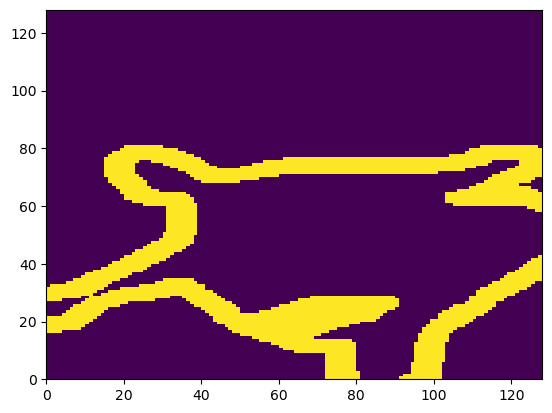

In [57]:
plt.pcolormesh(train_target[0, 2, ...])

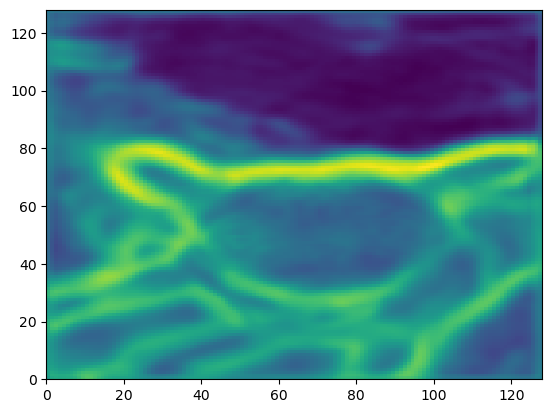

In [58]:
plt.pcolormesh(y_pred[0, 2, ...])